# Using the pycpt package to read color palette table files from cpt-city

Color Palette Table (CPT) files define colormaps as piecewise-constant color bands between numeric boundaries. This notebook shows how `pycpt` reads CPTs (bundled from the [cpt-city](http://seaviewsensing.com/pub/cpt-city/) archive), preserves their original boundaries, and makes them easy to use in Matplotlib. 

We recommend to read the [cpt-city](http://seaviewsensing.com/pub/cpt-city/) archive license and terms of use, and acknowledge the original authors when using their palettes.

In [31]:
import pycpt

## Reading a CPT file

`pycpt.read` accepts either a short name relative to the bundled cpt-city archive (e.g., `"cmocean/algae"`, `"cl/fs2010"`, or simply `"algae"` when unique), or a file path on disk. The file extension is optional; `.cpt` is added automatically. You can also set the logical palette type with `kind` ("sequential" or "diverging"). In the next cell, we read a palette by short name, preview its discrete bands, and check how many segments it has.


29

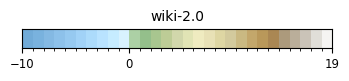

In [25]:
palette = pycpt.read("wiki-2.0")
palette.plot()
palette.n_colors

## Color data structure

CPTs describe discrete segments with explicit numeric boundaries. In `pycpt`:
- `palette.levels` are the sorted boundary values (length `n_colors + 1`).
- `palette.intervals` is a `pandas.IntervalIndex` pairing consecutive boundaries into closed intervals `[z0, z1]`.
- `palette.cmap` is a `ListedColormap` with one solid color per segment (left endpoint color).
- `palette.norm` is a `BoundaryNorm` that maps the original `levels` to the colormap without rescaling.

This “boundaries first” design means your plots can reproduce the palette author’s intent exactly. If you prefer a smoother appearance, you can call `palette.interpolate(n=...)` to increase the number of bands.

In [26]:
palette.intervals  #

IntervalIndex([[-10.0, -9.0],  [-9.0, -8.0],  [-8.0, -7.0],  [-7.0, -6.0],
                [-6.0, -5.0],  [-5.0, -4.0],  [-4.0, -3.0],  [-3.0, -2.0],
                [-2.0, -1.0],   [-1.0, 0.0],    [0.0, 1.0],    [1.0, 2.0],
                  [2.0, 3.0],    [3.0, 4.0],    [4.0, 5.0],    [5.0, 6.0],
                  [6.0, 7.0],    [7.0, 8.0],    [8.0, 9.0],   [9.0, 10.0],
                [10.0, 11.0],  [11.0, 12.0],  [12.0, 13.0],  [13.0, 14.0],
                [14.0, 15.0],  [15.0, 16.0],  [16.0, 17.0],  [17.0, 18.0],
                [18.0, 19.0]],
              dtype='interval[float64, both]')

## Try another colormap

You can load palettes from many families (e.g., `cmocean`, `xkcd`, `gmt`, `wkp`, …). Later in this notebook, we’ll list an entire family with `pycpt.files.get_family(...)` and preview each palette quickly.

Below we switch to another palette and preview its bands.

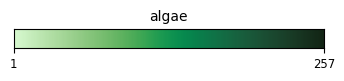

In [27]:
palette = pycpt.read("algae")
palette.plot()

## Using the colormap in Matplotlib

There are two common ways to apply a palette:
- Using only `cmap` lets Matplotlib rescale colors to your data range (smooth but may shift intended boundaries).
- Using `cmap` together with `palette.norm` preserves the original CPT boundaries (discrete bands at the authored values).

In the next code cell, the three panels show:
1) Left: `cmap` only (colors are rescaled to the data range).
2) Middle: `cmap + norm` (colors follow original boundaries).
3) Right: Same palette after `palette.scale(vmin, vmax)` and `palette.interpolate(n=...)`, then used with `cmap + norm` and a matching colorbar via `palette.colorbar(...)`.

Tip: For diverging data centered at a value, read with `kind="diverging"` and pass the center to `palette.scale(vmin, vmax, at=center)` so left/right segments preserve their balance.

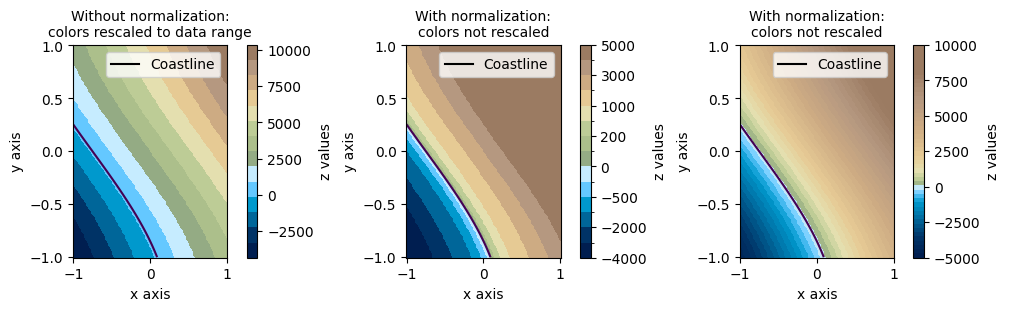

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
x = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, x)
z = 4000 * (x + np.sin(y) + 0.5) + 1000

# Get colormap and norm from palette
palette = pycpt.read("colombia", kind="diverging")

# Create figure
fig, ax = plt.subplots(figsize=(10, 3), ncols=3, constrained_layout=True)

# Without norm

# norm = mcolors.TwoSlopeNorm(vmin=-10000, vcenter=+1000, vmax=4000)
# norm = palette.norm_to(z, diverging=True)
img = ax[0].pcolormesh(x, y, z, cmap=palette.cmap)
ax[0].contour(x, y, z, levels=[0])
fig.colorbar(img, ax=ax[0], label="z values", pad=0.1)
label = "Without normalization:\ncolors rescaled to data range"
ax[0].set_title(label, size="medium")
ax[0].set_xlabel("x axis")
ax[0].set_ylabel("y axis")
ax[0].plot(np.nan, np.nan, "k", label="Coastline")
ax[0].legend()

# With norm
img = ax[1].pcolormesh(x, y, z, norm=palette.norm, cmap=palette.cmap)
fig.colorbar(img, ax=ax[1], label="z values", pad=0.1, norm=palette.norm)
ax[1].contour(x, y, z, levels=[0])
label = "With normalization:\ncolors not rescaled"
ax[1].set_title(label, size="medium")
ax[1].set_xlabel("x axis")
ax[1].set_ylabel("y axis")
ax[1].plot(np.nan, np.nan, "k", label="Coastline")
ax[1].legend()

# With norm
palette.scale(-5000, 10000)
palette.interpolate(n=50)
img = ax[2].pcolormesh(x, y, z, norm=palette.norm, cmap=palette.cmap)
# cb = fig.colorbar(palette.mappable, ax=ax[2], label="z values", pad=0.1)
palette.colorbar(ax=ax[2], label="z values", pad=0.1)
ax[2].contour(x, y, z, levels=[0])
label = "With normalization:\ncolors not rescaled"
ax[2].set_title(label, size="medium")
ax[2].set_xlabel("x axis")
ax[2].set_ylabel("y axis")
ax[2].plot(np.nan, np.nan, "k", label="Coastline")
ax[2].legend()

## Playing with continuous and discrete palettes

CPTs are inherently discrete. You can increase visual smoothness by interpolating additional bands while preserving the palette’s spirit:
- `palette.scale(vmin, vmax, at=None)` remaps the boundaries to a new numeric range (for diverging palettes, set `kind="diverging"` at read time and pass `at` to keep the center aligned).
- `palette.interpolate(n)` resamples the palette to `n` segments by building a temporary continuous colormap from the endpoints and sampling it evenly.

Guideline:
- If you care about honoring the authored boundaries, prefer `cmap + palette.norm`.
- If you want a smoother look, call `interpolate` (e.g., `n=256`) and still use `palette.norm` to preserve the (now denser) boundaries.
- If you truly want continuous shading without discrete steps, consider using the temporary continuous colormap pattern directly in your own plotting code.

-8265.86701393578 8138.76631600238


Text(0, 0.5, 'y axis')

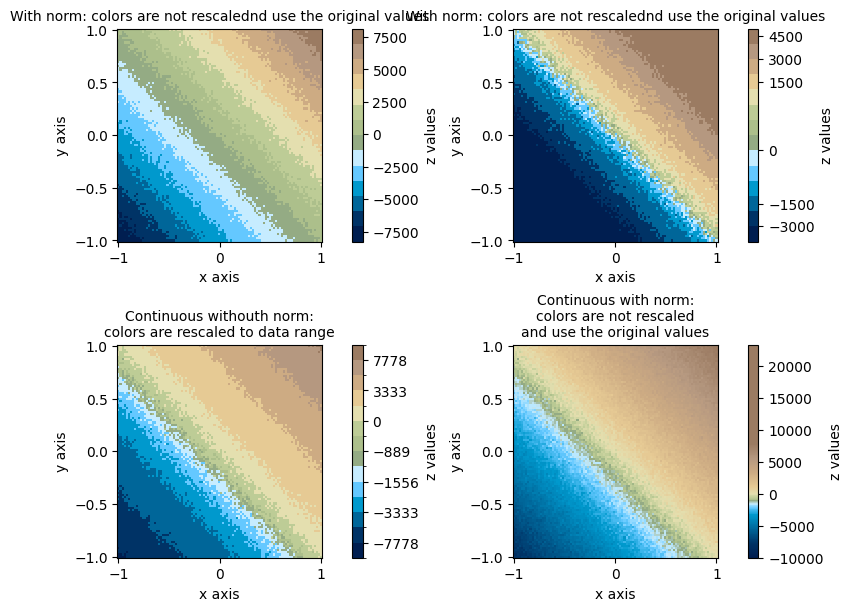

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
x = np.linspace(-1, 1, 100)
x, y = np.meshgrid(x, x)
z = 4000 * (x + y) + np.random.randn(100, 100) * 200
print(z.min(), z.max())

# Get colormap and norm from palette
palette = pycpt.read("colombia")

# Create figure
fig, ax = plt.subplots(
    figsize=(8, 6), ncols=2, nrows=2, constrained_layout=True
)
ax = ax.ravel()


# Wthout norm
# cmap = palette.to_matplotlib(with_norm=False)
img = ax[0].pcolormesh(x, y, z, cmap=palette.cmap)
fig.colorbar(img, ax=ax[0], label="z values", pad=0.1)
label = "With norm: colors are not rescaled\
nd use the original values"
ax[0].set_title(label, size="medium")
ax[0].set_xlabel("x axis")
ax[0].set_ylabel("y axis")

# With norm
img = ax[1].pcolormesh(x, y, z, cmap=palette.cmap, norm=palette.norm)
palette.colorbar(ax=ax[1], label="z values", pad=0.1, norm=palette.norm)

bel = "With norm: colors are not rescaled\nand use the original values"
ax[1].set_title(label, size="medium")
ax[1].set_xlabel("x axis")
ax[1].set_ylabel("y axis")

# Continuous without norm
palette.scale(-10000, 10000)
# cmap = palette.to_matplotlib(continuous=True, with_norm=False)
img = ax[2].pcolormesh(x, y, z, cmap=palette.cmap, norm=palette.norm)
fig.colorbar(img, ax=ax[2], label="z values", pad=0.1)
label = "Continuous withouth norm:\ncolors are rescaled to data range"
ax[2].set_title(label, size="medium")
ax[2].set_xlabel("x axis")
ax[2].set_ylabel("y axis")

# Continuous with norm
palette.interpolate(n=256)
img = ax[3].pcolormesh(x, y, z, cmap=palette.cmap, norm=palette.norm)
palette.colorbar(ax=ax[3], label="z values", pad=0.1, norm=palette.norm)
label = "Continuous with norm:\ncolors are not rescaled\nand use the original values"
ax[3].set_title(label, size="medium")
ax[3].set_xlabel("x axis")
ax[3].set_ylabel("y axis")

## Listing and previewing a palette family

`pycpt.files.get_family(name)` returns all CPT files under a given family. This is handy to browse a collection and quickly preview each palette’s discrete bands.

Below, we grid a few palettes from the `wkp` family and call `palette.plot` on each. Unused axes are hidden for clarity.

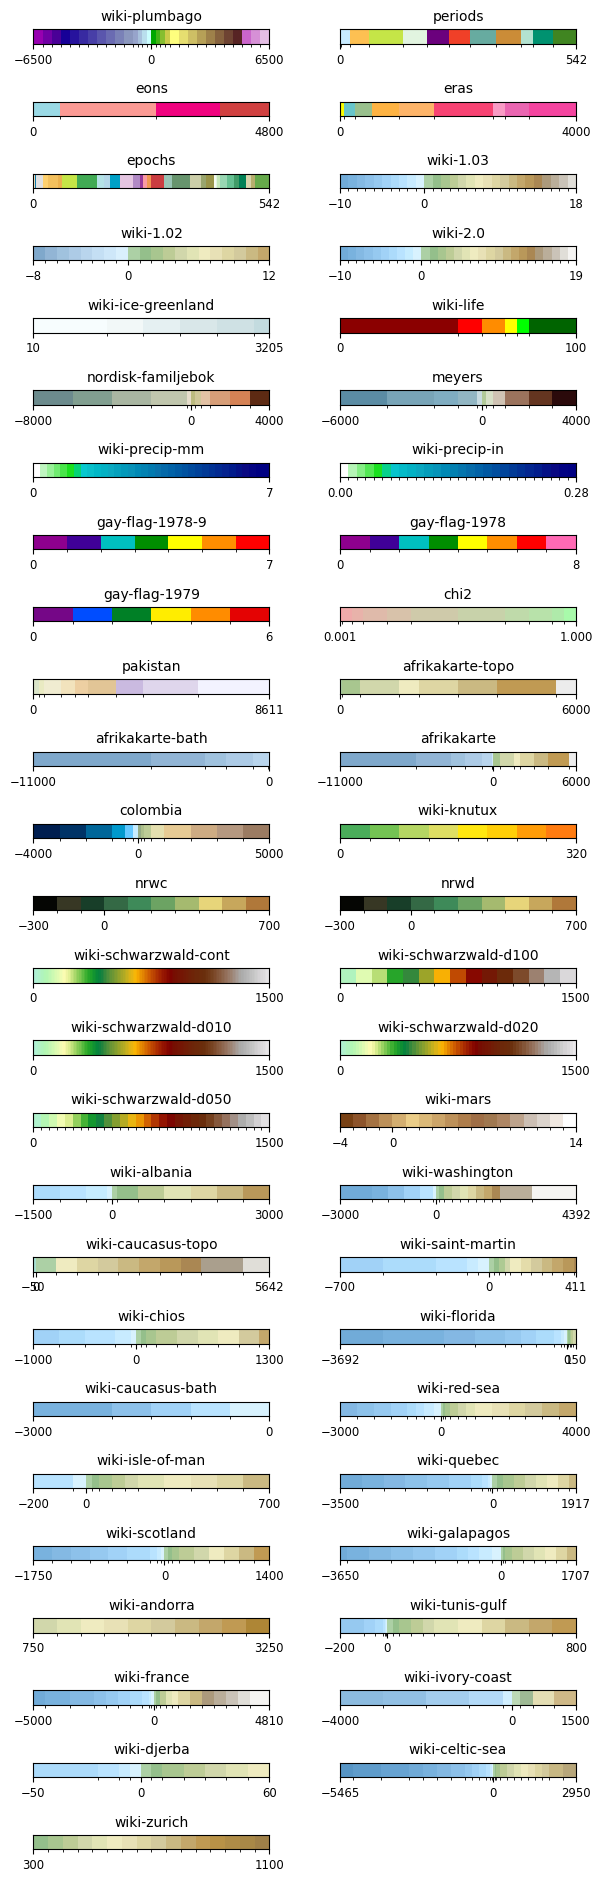

In [30]:
files = pycpt.get_family("wkp")

n_cols = 2
n_rows = int(np.ceil(len(files) / n_cols))
fig, ax = plt.subplots(
    figsize=(7, n_rows / 1.1),
    ncols=n_cols,
    nrows=n_rows,
    gridspec_kw={"wspace": 0.3, "hspace": 4},
)
ax = ax.ravel()
for i, filepath in enumerate(files):
    palette = pycpt.read(filepath)
    palette.plot(ax=ax[i])

# Clear unused axes
for j in range(i + 1, len(ax)):
    ax[j].axis("off")